In [3218]:
% reset
% config InlineBackend.figure_format = 'retina'

import numpy as np
import scipy as sp
import statsmodels.api as sm
from scipy import signal
from scipy import stats
from scipy.optimize import curve_fit
import itertools
from operator import itemgetter

import h5py

import foof_utils as fu

% matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 12
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3219]:
# helper functions

def data_syn(filename, freq_range):
#     filename = '6.npy'
#     freq_range = [3, 50]
    psd_array = np.load(filename)
    psd_array = np.log10(psd_array)

    range_size = (np.size(range(freq_range[1]))-0.5)-(np.size(range(freq_range[0]))-1.5)
    xf = np.linspace(freq_range[0], freq_range[1], range_size)
    
    return psd_array,xf

def data_eeg(filename, freq_range):
#     filename = 'g1025_ch07_raw.npy'
#     freq_range = [0, 50]
    psd_array = np.load(filename)
    psd_array = np.log10(psd_array)

    range_size = np.size(range(freq_range[1]))-np.size(range(freq_range[0]))
    xf = np.linspace(freq_range[0], freq_range[1], range_size)
    
    psd_array = psd_array.T
    
    return psd_array,xf

def data_ecog(filename, srate, channel):
#     filename = 'ecog_data.csv'
#     srate = 1000.0
    chandat = np.loadtxt(filename, delimiter=",")
    chandat = chandat[:, channel]

    # make the PSD
    window_size = int(srate*5)
    overlap = int(window_size * 0.5)

    xf, _, psd_array = signal.spectrogram(chandat, fs=srate, window=('hanning'), nperseg=window_size, noverlap=overlap)
    psd_array = np.log10(psd_array)
    
    return psd_array,xf

def data_synthesize(freq_range, freq_points, slope_params, oscillation_params, noise_params, n_samples):
    # simulate spectrum as opposed to using real data
    xf = np.linspace(freq_range[0], freq_range[1], freq_points)
    
    psd_array = fu.simulate_neural_spectra(xf, slope_params, oscillation_params, noise_params)

    for i in range(n_samples-1):
        simulated_spectrum = fu.simulate_neural_spectra(xf, slope_params, oscillation_params, noise_params)
        psd_array = np.vstack((psd_array, simulated_spectrum))  

    psd_array = psd_array.T
    
    return psd_array,xf




def get_index_from_vector(input_vector, element_value):
    loc = input_vector-element_value
    idx = np.where(np.abs(loc)==np.min(np.abs(loc)))
    idx = idx[0][0]
    
    return idx

def trim_psd(input_psd, input_frequency_vector, frequency_range):
    idx = [0, 0]
    idx[0] = get_index_from_vector(input_frequency_vector, frequency_range[0])
    idx[1] = get_index_from_vector(input_frequency_vector, frequency_range[1])

    output_frequency_vector = input_frequency_vector[idx[0]:idx[1]]
    trimmed_psd = input_psd[idx[0]:idx[1], :]
    
    return output_frequency_vector, trimmed_psd

def fit_one_over_f(frequency_vector, trimmed_psd):
    # 2nd degree polynomial robust fit for first pass
    Xvar = np.column_stack((frequency_vector, frequency_vector**2))
    Xvar = sm.add_constant(Xvar)
    # logic in case RLM fails
    try:
        mdl_fit = sm.RLM(trimmed_psd, Xvar, M=sm.robust.norms.TukeyBiweight()).fit()
    except:
        mdl_fit = sm.OLS(trimmed_psd, Xvar).fit()
    fit_values = mdl_fit.fittedvalues
    fit_parameters = mdl_fit.params

    return fit_values, fit_parameters

# gaussian function
def gaussian_function(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)

    return y

def fit_gaussian(flattened_psd, frequency_vector, window_around_max):
    
    # find the location and amplitude of the maximum of the flattened spectrum
    # this assumes that this value is the peak of the biggest oscillation
    max_index = np.argmax(flattened_psd)
    guess_freq = frequency_vector[max_index]

    # set everything that's not the biggest oscillation to zero
    p_flat_zeros = flattened_psd - 0
    
    idx = [0, 0]
    idx[0] = get_index_from_vector(frequency_vector, guess_freq-window_around_max)
    idx[1] = get_index_from_vector(frequency_vector, guess_freq+window_around_max)
    
    # if the cf is near left edge, only flatten to the right
    if (guess_freq-window_around_max)<window_around_max:
        p_flat_zeros[idx[1]:] = 0
    # if the cf is near right edge, only flatten to the left
    elif (guess_freq+window_around_max)>(np.max(frequency_vector)-window_around_max):
        p_flat_zeros[0:idx[0]] = 0
    # otherwise flatten it all
    else:
        p_flat_zeros[0:idx[0]] = 0
        p_flat_zeros[idx[1]:] = 0

    # the first guess for the gaussian fit is the biggest oscillation
    guess = [guess_freq, np.max(p_flat_zeros), 2]
    guess = np.array(guess)
    popt, _ = curve_fit(gaussian_function, frequency_vector, p_flat_zeros, p0=guess, maxfev=5000)
    gaussian_fit = gaussian_function(frequency_vector, *popt)
    gaussian_fit = np.array(gaussian_fit)

    return popt, gaussian_fit

def adjusted_r2(r2, n, k):
    return 1 - (((1-r2)*(n-1))/(n-k-1))

# decision criteria for keeping fitted oscillations
# amp has to be at least 1.645 * residual noise
# std of gaussian fit needs to not be too narrow...
# ... nor too wide
# and cf of oscillation can't be too close to edges, else there's not enough infomation to make a good fit
def decision_criterion(oscillation_params, frequency_range, edge_criteria):
    keep_parameter = \
        (oscillation_params[2] < 5.) & \
        (oscillation_params[2] > 0.5) & \
        (oscillation_params[0] > (frequency_range[0]+edge_criteria)) & \
        (oscillation_params[0] < (frequency_range[1]-edge_criteria))

    return keep_parameter




def fooof(frequency_vector, input_psd, frequency_range, number_of_gaussians, window_around_max):
    
    if input_psd.ndim>2:
        raise ValueError("input PSD must be 1- or 2- dimensional")
        
    # outlier amplitude is also the minimum amplitude required for counting as an "oscillation"
    # this is express as percent relative maximum oscillation height
    threshold = 0.025
        
    # trim the PSD
    frequency_vector, foof_spec = trim_psd(psd_array, frequency_vector, frequency_range)

    # check dimensions
    if np.shape(frequency_vector)[0]==np.shape(foof_spec)[0]:
        foof_spec = foof_spec.T

    trimmed_psd = np.nanmean(foof_spec,0)

    # fit in log-log space and flatten the PSD
    log_f = np.log10(frequency_vector)
    _,background_params = fit_one_over_f(log_f, trimmed_psd)    
    fit_values = background_params[0] + (background_params[1]*(log_f)) + (background_params[2]*(log_f**2))
    p_flat = trimmed_psd - fit_values
    
    # remove outliers
    p_flat[p_flat<0] = 0
    amplitude_threshold = np.max(p_flat)*threshold
    cutoff = p_flat<=(amplitude_threshold)
    f_ignore = frequency_vector[cutoff]
    p_ignore = trimmed_psd[cutoff]

    # refit the background, ignoring regions with large amplitudes
    # this assumes those large amplitude regions are oscillations, not background
    log_f_ignore = np.log10(f_ignore)
    _,background_params = fit_one_over_f(log_f_ignore, p_ignore)
    background_fit = background_params[0] + (background_params[1]*(log_f)) + (background_params[2]*(log_f**2))
    p_flat_real = trimmed_psd - background_fit
    amplitude_threshold = np.max(p_flat_real)*threshold
    
    p_flat_real[p_flat_real<0] = 0
    p_flat_iteration = p_flat_real - 0
    
    # initialize
    oscillation_params = np.empty((0,3)) # cf, amp, bw
    gaussian_fit = np.empty((0,np.size(frequency_vector)))

    edge_criteria = 1.

    # fit gaussians
    for i in range(number_of_gaussians):
        try:
            popt, output_gaussian = fit_gaussian(p_flat_iteration, frequency_vector, window_around_max)
            keep_parameter = decision_criterion(popt, frequency_range, edge_criteria)
            
            if keep_parameter:
                oscillation_params = np.vstack((oscillation_params, popt))
                gaussian_fit = np.vstack((gaussian_fit, output_gaussian))
                p_flat_iteration = p_flat_real - np.sum(gaussian_fit,0)

        except:
            pass # this needs exception handling in case fitting fails

    # remove any duplicates
    oscillation_params = [list(x) for x in set(tuple(x) for x in oscillation_params)]
    gaussian_fit = [list(x) for x in set(tuple(x) for x in gaussian_fit)]

    psd_fit = np.sum(gaussian_fit,0) + background_fit
    
    # logic handle background fit when there are no oscillations
    if len(oscillation_params)==0:
        # 2nd degree polynomial robust fit for first pass
        Xvar = np.column_stack((frequency_vector, frequency_vector**2))
        Xvar = sm.add_constant(Xvar)
        mdl_fit = sm.RLM(trimmed_psd, Xvar, M=sm.robust.norms.TukeyBiweight()).fit()
        background_params = mdl_fit.params
        background_fit = background_params[0] + (background_params[1]*(frequency_vector)) + (background_params[2]*(frequency_vector**2))
        psd_fit = background_fit

    return p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params


[-1.42134015  1.37990743 -1.37065233]
[[31.061709071780996, 0.36723611524567645, 1.6280149754925795], [20.716344859991995, 0.92086918344880397, 2.8325443978296003], [16.152268448730553, 0.39635386093092484, 2.0429443060966417], [27.728586923634474, 1.0143735463784582, 2.839614563396009], [23.748001902944658, 0.30002407234782091, 1.3835385307292378]]


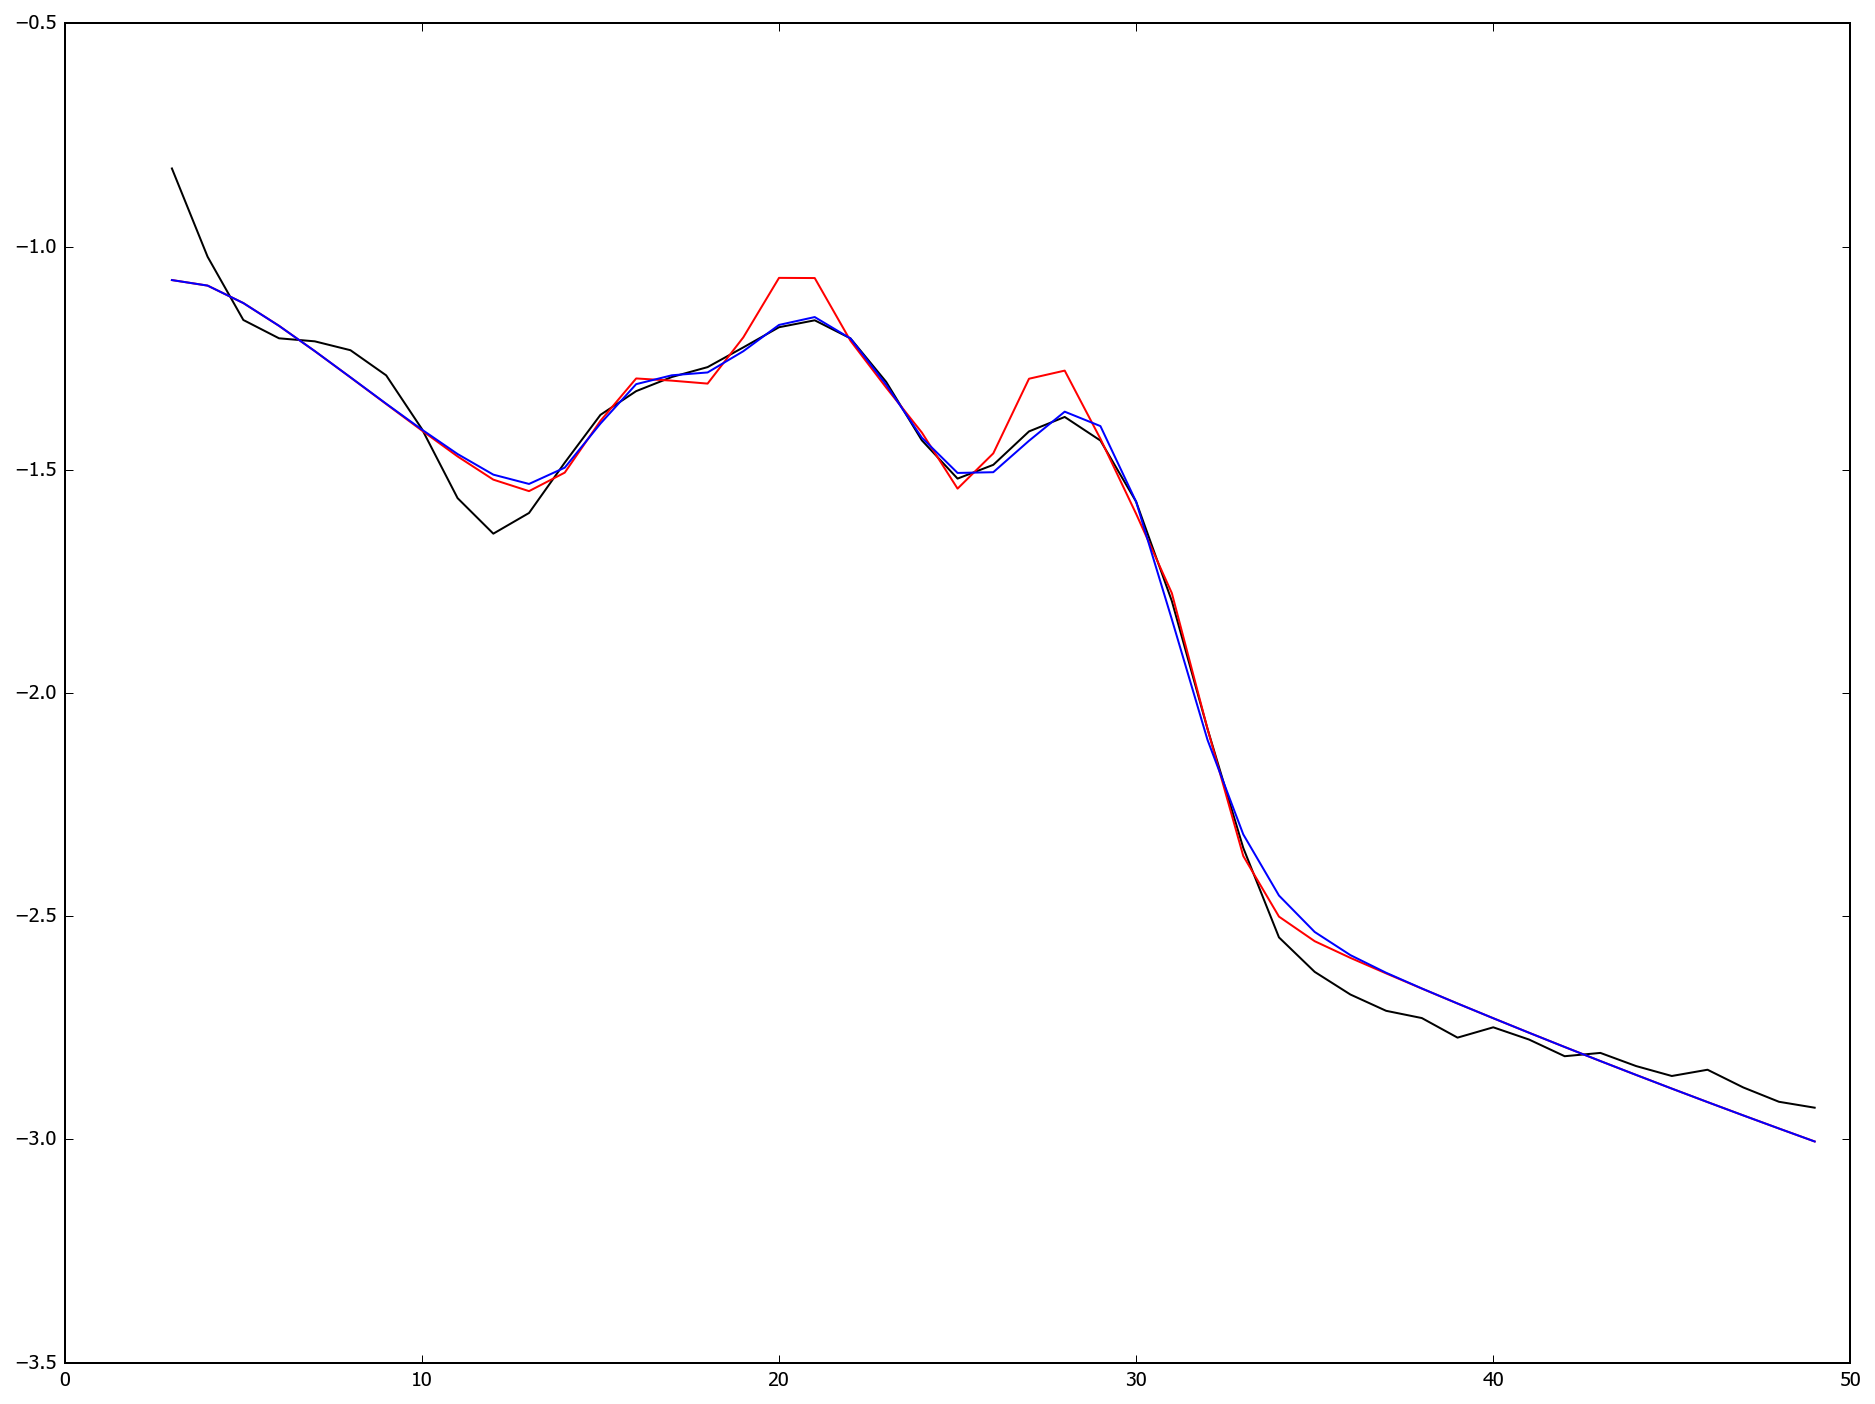

In [3220]:
# filename = 'eeg_9.npy'
# freq_range = [0, 50]
# psd_array,xf = data_eeg(filename, freq_range)

# filename = 'ecog_data.csv'
# srate = 1000.
# channel = 0
# psd_array,xf = data_ecog(filename, srate, channel)

# freq_range = [1, 50]
# freq_points = 100
# slope_params = [5.11, -0.0567, 0.00059]
# oscillation_params = [[0.53, 7.98, 1.7],[0.53, 9.3, 2.3],[0.13, 23.1, 3.3]]
# noise_params = [0.0, 0.1]
# n_samples = 100
# psd_array,xf = data_synthesize(freq_range, freq_points, slope_params, oscillation_params, noise_params, n_samples)

filename = '46.npy'
freq_range = [3, 50]
psd_array,xf = data_syn(filename, freq_range)

window_around_max = 3
cut_freqs = [3, 50]
number_of_gaussians = 6
p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
    fooof(xf, psd_array, cut_freqs, number_of_gaussians, window_around_max)

guess = oscillation_params
guess = sorted(guess, key=itemgetter(1), reverse=True)

popt, _ = curve_fit(gaussian_function, frequency_vector, p_flat_real, p0=guess[0:3][:], maxfev=5000)
multi_fit = gaussian_function(frequency_vector, *popt)

print(background_params)
print(oscillation_params)

plt.plot(frequency_vector, trimmed_psd, 'k')
plt.plot(frequency_vector, psd_fit, 'r')
plt.plot(frequency_vector, multi_fit+background_fit, 'b')
plt.show()
